In [1]:
import os

import pandas as pd
import torch
import torch.nn as nn
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoConfig
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
def get_company_dataset(company, tokenizer, max_length=64, test_size=0.2):

    df = pd.read_csv(f"{company}.csv")

    #  Label Encoding (Local to this company/dataset)
    # If global consistency needed across companies, pass fitted encoders instead.
    type_encoder = LabelEncoder()
    code_encoder = LabelEncoder()

    df['cc_type_id'] = type_encoder.fit_transform(df['cc_type'])
    df['cc_code_id'] = code_encoder.fit_transform(df['cc_code'])

    # Calculate dimensions for the model heads
    num_type_labels = len(type_encoder.classes_)
    num_code_labels = len(code_encoder.classes_)

    print(f"Dataset Loaded: {len(df)} records")
    print(f"Found {num_type_labels} Transaction Types and {num_code_labels} GL Codes.")

    # 3. Stratified Train/Test Split
    # We create a temporary 'stratify_col' to ensure both Type and Code distributions are preserved
    df['stratify_col'] = df['cc_type'].astype(str) + "_" + df['cc_code'].astype(str)

    train_df, val_df = train_test_split(
        df,
        test_size=test_size,
        random_state=42,
        stratify=df['stratify_col']  # Critical for rare GL codes
    )

    train_df.to_csv(f"Training_Data_{company}.csv", index=False)
    val_df.to_csv(f"Val_Data_{company}.csv", index=False)
    
    # Cleanup auxiliary columns
    cols_to_keep = ['merchant_group', 'merchant_name', 'cc_type_id', 'cc_code_id']
    train_df = train_df[cols_to_keep]
    val_df = val_df[cols_to_keep]

    # 4. Convert to Hugging Face Datasets
    train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
    val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

    # 5. Tokenization Function
    def preprocess_function(examples):
        # Manual concatenation for Qwen/LLMs
        inputs = [f"{g} | {n}" for g, n in zip(examples["merchant_group"], examples["merchant_name"])]

        tokenized_inputs = tokenizer(
            inputs,  # Single list of strings
            truncation=True,
            max_length=max_length,
            padding="max_length"  # Or False if using DataCollator
        )

        tokenized_inputs["labels_type"] = examples["cc_type_id"]
        tokenized_inputs["labels_code"] = examples["cc_code_id"]
        return tokenized_inputs

    # 6. Apply Processing
    # We remove the text columns to leave only the tensors
    remove_cols = train_dataset.column_names

    train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=remove_cols)
    val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=remove_cols)

    # 7. Set Format for PyTorch
    target_columns = ["input_ids", "attention_mask", "labels_type", "labels_code"]
    train_dataset.set_format(type="torch", columns=target_columns)
    val_dataset.set_format(type="torch", columns=target_columns)

    return {
        "train": train_dataset,
        "val": val_dataset,
        "num_type_labels": num_type_labels,
        "num_code_labels": num_code_labels,
        "encoders": {"type": type_encoder, "code": code_encoder}
    }


In [3]:
def get_company_dataset_Hard_Val(company, tokenizer, max_length=64):

    df = pd.read_csv(f"hard_val_{company}.csv")

    #  Label Encoding (Local to this company/dataset)
    # If global consistency needed across companies, pass fitted encoders instead.
    type_encoder = LabelEncoder()
    code_encoder = LabelEncoder()

    df['cc_type_id'] = type_encoder.fit_transform(df['cc_type'])
    df['cc_code_id'] = code_encoder.fit_transform(df['cc_code'])

    # Calculate dimensions for the model heads
    num_type_labels = len(type_encoder.classes_)
    num_code_labels = len(code_encoder.classes_)

    print(f"Dataset Loaded: {len(df)} records")
    print(f"Found {num_type_labels} Transaction Types and {num_code_labels} GL Codes.")

    # 3. Stratified Train/Test Split
    # We create a temporary 'stratify_col' to ensure both Type and Code distributions are preserved
    df['stratify_col'] = df['cc_type'].astype(str) + "_" + df['cc_code'].astype(str)

    # Cleanup auxiliary columns
    cols_to_keep = ['merchant_group', 'merchant_name', 'cc_type_id', 'cc_code_id']
  
    val_df = df[cols_to_keep]

    val_dataset = Dataset.from_pandas(val_df, preserve_index=False)


    # 5. Tokenization Function
    def preprocess_function(examples):
        # Manual concatenation for Qwen/LLMs
        inputs = [f"{g} | {n}" for g, n in zip(examples["merchant_group"], examples["merchant_name"])]

        tokenized_inputs = tokenizer(
            inputs,  # Single list of strings
            truncation=True,
            max_length=max_length,
            padding="max_length"  # Or False if using DataCollator
        )

        tokenized_inputs["labels_type"] = examples["cc_type_id"]
        tokenized_inputs["labels_code"] = examples["cc_code_id"]
        return tokenized_inputs

    # 6. Apply Processing
    # We remove the text columns to leave only the tensors
    remove_cols = val_dataset.column_names
    val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=remove_cols)

    # 7. Set Format for PyTorch
    target_columns = ["input_ids", "attention_mask", "labels_type", "labels_code"]
    val_dataset.set_format(type="torch", columns=target_columns)

    return {
        "val": val_dataset,
        "num_type_labels": num_type_labels,
        "num_code_labels": num_code_labels,
        "encoders": {"type": type_encoder, "code": code_encoder}
    }


In [4]:
class QwenMultiHeadClassifier(nn.Module):
    def __init__(self, model_id, num_type_labels, num_code_labels, lora_config=None):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_id)
        self.qwen = AutoModel.from_pretrained(
            model_id,
            #allows the library to download and execute custom Python code found in the model's Hugging Face Hub repository, 
            #rather than using the standard code built into the transformers librar
            trust_remote_code=True, 
            device_map=None # CUDA
        )

       # print(f"VANILLA QWEN ARCHITECTURE : \n {self.qwen}")

        if lora_config is not None:
            self.qwen = get_peft_model(self.qwen, lora_config)
            self.qwen.print_trainable_parameters()

        # Two separate Head for Code and Type , hiodeen size of model , 1536 for Qwen .

        self.type_head = nn.Linear(self.config.hidden_size, num_type_labels)
        self.code_head = nn.Linear(self.config.hidden_size, num_code_labels)

        # changing heads added to QWEN Data Type DFloat16 
        self.type_head.to(self.qwen.dtype) 
        self.code_head.to(self.qwen.dtype)

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None,
                    labels_type = None, labels_code = None, **kwargs):
            outputs = self.qwen(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
            # Extract Last Token Embedding (EOS token), for LLMs, use Last Hidden State of last token
            # shape : [batch, seq_length, hidden]
            last_hidden_state = outputs.last_hidden_state
            #print( "Shape of last hidden state %",last_hidden_state.shape )
            #Shape of last hidden state = torch.Size([32, 64, 1536])
            # Get Embedding of last token for Classification
            if self.config.pad_token_id is None:  # Fallback if no pad token
                sequence_lengths = -1
            else:
                if input_ids is not None:  # Find last non paddign token
                    sequence_lengths = (torch.ne(input_ids, self.config.pad_token_id).sum(-1) - 1).to(last_hidden_state.device)
                else:
                    sequence_lengths = -1

            # Get the Vector for last token in the sequence using sequence lenght calced above
            #last_hidden_state shape: (Batch_Size, Sequence_Length, Hidden_Size)
            # last_hidden_state[0] = batch size
            # sequence_lengths contains last token indexes for each sequence .
            # Last token is sequence is like CLS token it has learnt about the sequence 
            pooled_output = last_hidden_state[torch.arange(last_hidden_state.shape[0]), sequence_lengths]

            # Pass it tot he linear layers like we do CLS Token in Transforemrs
            logits_type = self.type_head(pooled_output)
            logits_code = self.code_head(pooled_output)

            loss = None

            if labels_type is not None and labels_code is not None:
                loss_type = self.loss_fn(logits_type, labels_type)
                loss_code = self.loss_fn(logits_code, labels_code)
                loss = 2 * loss_type + 1 * loss_code
            else :
                loss = torch.tensor(0.0, device=input_ids.device, requires_grad=True)

            # Form output that can work with Huggingface trainer
            output = {
                "logits": (logits_type, logits_code)
                }

            # Add optional keys ONLY if they are not None, this is to avoid failure in Validation Run
            if loss is not None:
                output["loss"] = loss

            if getattr(outputs, "hidden_states", None) is not None:
                output["hidden_states"] = outputs.hidden_states

            if getattr(outputs, "attentions", None) is not None:
                output["attentions"] = outputs.attentions

            return output



In [5]:
class CustomTrainer(Trainer):
    def save_model(self, output_dir=None, _internal_call=False):
        # Save the LoRA adapters (standard behavior)
        # Checks if model is wrapped in PEFT
        if output_dir is None:
            output_dir = self.args.output_dir

        # Save LoRA weights
        self.model.qwen.save_pretrained(output_dir)

        # MANUALLY save your custom heads
        torch.save(self.model.type_head.state_dict(), f"{output_dir}/type_head.bin")
        torch.save(self.model.code_head.state_dict(), f"{output_dir}/code_head.bin")

        # Save tokenizer
        self.tokenizer.save_pretrained(output_dir)



In [6]:
model_id = "Qwen/Qwen2.5-1.5B"

tokenizer = AutoTokenizer.from_pretrained(model_id,  trust_remote_code=True,  use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
training_modes = ["company_adapter", "global_adapter"]
adapter_name_global = "adapter_global"
global_adapter_path = "./final_adapters_QWEN/global"

companies = ["company_D", "company_E", "company_F"]  #  list of companies

peft_config = LoraConfig(
    #treat the Qwen backbone as a feature extractor.as we have custom multihead QWEN ,
    # normal classification this would have been SEQ_CLS
    # classification heads are external to the PEFT wrapper here
    task_type=TaskType.FEATURE_EXTRACTION, 
    r=8, # 16 RANk is good , LORA Mattrices will be A X R and R X B . 
    lora_alpha=16, # Scales Output of Lora adapter by Alpha / Rank . ( 32/16 for us) , Makes learnt weights LOUDER compared to base model weights .
    #Scale of 2 is good . 
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], # Q K V and Output Projections selected to train as part of adapter 
    # MLP Layers are gate_proj, up_proj, down_proj , but results in very large number of paramters to learn but also gives huge accuracy benefit . 
    lora_dropout=0.2 # Prevents overfittig whern data sizes are small like our company data case. 
)


# 4. Training Loop
for company in companies:
    print(f"Training adapter for: {company}")  
    for training_mode in training_modes:
        print(f"training mode : {training_mode}")
        # Format: "Merchant Group: {grp} [SEP] Merchant Name: {name}"
        data_bundle = get_company_dataset(company, tokenizer)
    
    
        train_dataset = data_bundle["train"]
        val_dataset = data_bundle["val"]
        num_type_labels = data_bundle["num_type_labels"]
        num_code_labels = data_bundle["num_code_labels"]
    
        model = QwenMultiHeadClassifier(
            model_id=model_id,
            num_type_labels=num_type_labels,
            num_code_labels=num_code_labels,
            lora_config=peft_config
        )
    
        # If it's the first run, the 'default' adapter is active.
        # For subsequent runs, we add a new adapter.
        adapter_name_company = f"adapter_{company}"
    
        try:
            if training_mode == "global_adapter":
                if os.path.exists(global_adapter_path):
                    print(f"Resuming Global Adapter from: {global_adapter_path}")
                    # Load weights from disk
                    model.qwen.load_adapter(global_adapter_path,
                                                 adapter_name=adapter_name_global, is_trainable=True)
                else:
                    model.qwen.add_adapter(adapter_name=adapter_name_global, peft_config=peft_config)
                    model.qwen.set_adapter(adapter_name_global)
            elif training_mode == "company_adapter":
                model.qwen.add_adapter(adapter_name=adapter_name_company, peft_config=peft_config)
                model.qwen.set_adapter(adapter_name_company)
        except ValueError: pass
    
        # C. Train
        training_args = TrainingArguments(
            output_dir=f"./results/{company}",
            per_device_train_batch_size=32,
            num_train_epochs=3,
            save_strategy="no",  # We save manually to be safe
            learning_rate=2e-4,
            remove_unused_columns=False  # Important for custom models
        )
    
        custom_trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset
        )
    
        custom_trainer.train()
    
        metrics = custom_trainer.evaluate(eval_dataset=val_dataset)
        print(metrics)
    
        if training_mode == "company_adapter":
            save_path = f"./final_adapters_QWEN/{company}"
        elif training_mode == "global_adapter":
            save_path = global_adapter_path
        # Save Adapter & Heads
        # This saves the LoRA weights
        model.qwen.save_pretrained(save_path)
        torch.save(model.type_head.state_dict(), os.path.join(save_path, "type_head.bin"))
        torch.save(model.code_head.state_dict(), os.path.join(save_path, "code_head.bin"))
        # Cleanup to free VRAM for next company
        # delete_adapter removes the LoRA weights from memory
        if training_mode == "company_adapter":    
            model.qwen.delete_adapter(adapter_name_company)
        elif training_mode == "global_adapter":
             model.qwen.delete_adapter(adapter_name_global)


Training adapter for: company_D
training mode : company_adapter
Dataset Loaded: 10000 records
Found 14 Transaction Types and 26 GL Codes.


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1468.11it/s, Materializing param=norm.weight]                              


trainable params: 2,179,072 || all params: 1,545,893,376 || trainable%: 0.1410


Step,Training Loss
500,1.627693


{'eval_loss': 0.010789032094180584, 'eval_runtime': 16.7062, 'eval_samples_per_second': 119.716, 'eval_steps_per_second': 14.965, 'epoch': 3.0}


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter adapter_company_D was active which is now deleted. Setting active adapter to default.
  warnings.warn(


training mode : global_adapter
Dataset Loaded: 10000 records
Found 14 Transaction Types and 26 GL Codes.


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1184.60it/s, Materializing param=norm.weight]                              


trainable params: 2,179,072 || all params: 1,545,893,376 || trainable%: 0.1410


Step,Training Loss
500,1.641061


{'eval_loss': 0.020308777689933777, 'eval_runtime': 67.5511, 'eval_samples_per_second': 29.607, 'eval_steps_per_second': 3.701, 'epoch': 3.0}


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter adapter_global was active which is now deleted. Setting active adapter to default.
  warnings.warn(


Training adapter for: company_E
training mode : company_adapter
Dataset Loaded: 10000 records
Found 12 Transaction Types and 25 GL Codes.


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1195.93it/s, Materializing param=norm.weight]                              


trainable params: 2,179,072 || all params: 1,545,893,376 || trainable%: 0.1410


Step,Training Loss
500,1.454686


{'eval_loss': 0.0016679076943546534, 'eval_runtime': 123.7621, 'eval_samples_per_second': 16.16, 'eval_steps_per_second': 2.02, 'epoch': 3.0}


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter adapter_company_E was active which is now deleted. Setting active adapter to default.
  warnings.warn(


training mode : global_adapter
Dataset Loaded: 10000 records
Found 12 Transaction Types and 25 GL Codes.


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1215.68it/s, Materializing param=norm.weight]                              


trainable params: 2,179,072 || all params: 1,545,893,376 || trainable%: 0.1410
Resuming Global Adapter from: ./final_adapters_QWEN/global


Step,Training Loss
500,1.704573


{'eval_loss': 0.0008534088265150785, 'eval_runtime': 29.4878, 'eval_samples_per_second': 67.825, 'eval_steps_per_second': 8.478, 'epoch': 3.0}
Training adapter for: company_F
training mode : company_adapter
Dataset Loaded: 10000 records
Found 13 Transaction Types and 27 GL Codes.


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1151.52it/s, Materializing param=norm.weight]                              


trainable params: 2,179,072 || all params: 1,545,893,376 || trainable%: 0.1410


Step,Training Loss
500,1.615302


{'eval_loss': 0.032936155796051025, 'eval_runtime': 193.8598, 'eval_samples_per_second': 10.317, 'eval_steps_per_second': 1.29, 'epoch': 3.0}


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter adapter_company_F was active which is now deleted. Setting active adapter to default.
  warnings.warn(


training mode : global_adapter
Dataset Loaded: 10000 records
Found 13 Transaction Types and 27 GL Codes.


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1604.59it/s, Materializing param=norm.weight]                              


trainable params: 2,179,072 || all params: 1,545,893,376 || trainable%: 0.1410
Resuming Global Adapter from: ./final_adapters_QWEN/global


Step,Training Loss


AcceleratorError: CUDA error: an illegal memory access was encountered
Search for `cudaErrorIllegalAddress' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Loading Base Model (this takes time)...


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1477.53it/s, Materializing param=norm.weight]                              


QWEn Multihead with 2 linear heads :
 QwenMultiHeadClassifier(
  (qwen): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm):

Map: 100%|██████████| 2000/2000 [00:00<00:00, 54423.77 examples/s]



--- Validating: company_D ---



--- Random Sample Review for company_D ---
[1309] Type: Auto_RSY -> Auto_RSY ✅ | Code: 39331 -> 39331 ✅
[228] Type: Auto_BZE -> Auto_BZE ✅ | Code: 39641 -> 39641 ✅
[51] Type: Fee_CHW -> Fee_CHW ✅ | Code: 39116 -> 39116 ✅
[1518] Type: Auto_RSY -> Auto_RSY ✅ | Code: 33145 -> 33145 ✅
[563] Type: ACH_SMW -> ACH_SMW ✅ | Code: 33256 -> 33256 ✅
[501] Type: Auto_BZE -> Auto_BZE ✅ | Code: 34965 -> 34965 ✅
[457] Type: Auto_RSY -> Auto_RSY ✅ | Code: 32927 -> 32927 ✅
[285] Type: Wire_CHB -> Wire_CHB ✅ | Code: 35497 -> 35497 ✅
[1508] Type: Fee_LDP -> Fee_LDP ✅ | Code: 35634 -> 35634 ✅
[209] Type: Auto_BZE -> Auto_BZE ✅ | Code: 39641 -> 39641 ✅
=== Transaction Types ===
Precision: 0.9985 | Recall: 0.9985 | F1:     0.9985 for company : company_D
=== GL Codes ===
Precision: 0.9985 | Recall: 0.9985 | F1: 0.9985 for company : company_D
Generating Confusion Matrix for Transaction Types...


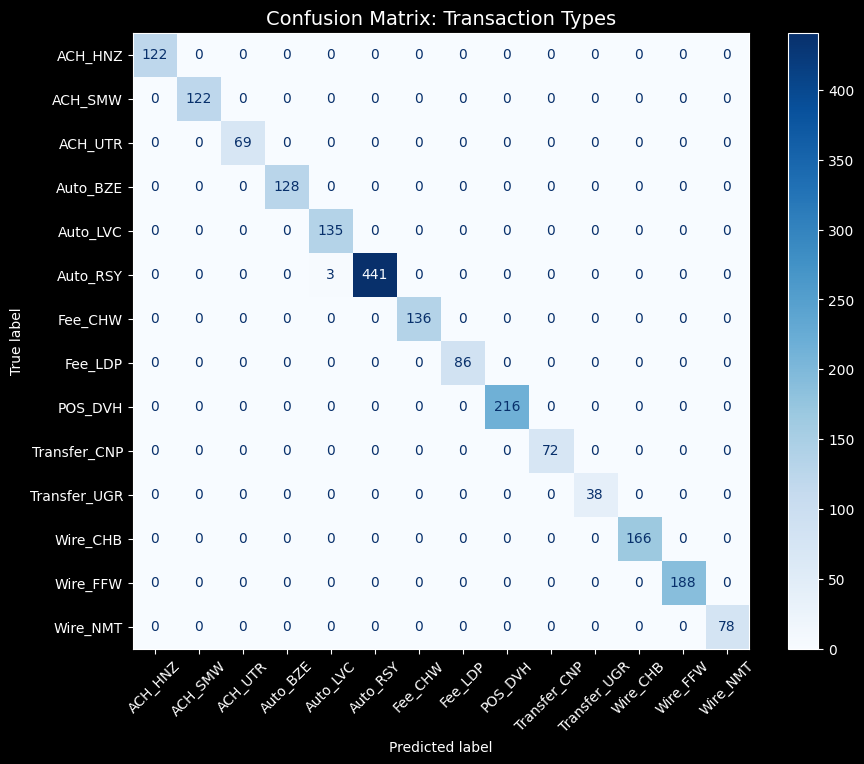

Generating Confusion Matrix for GL Codes...


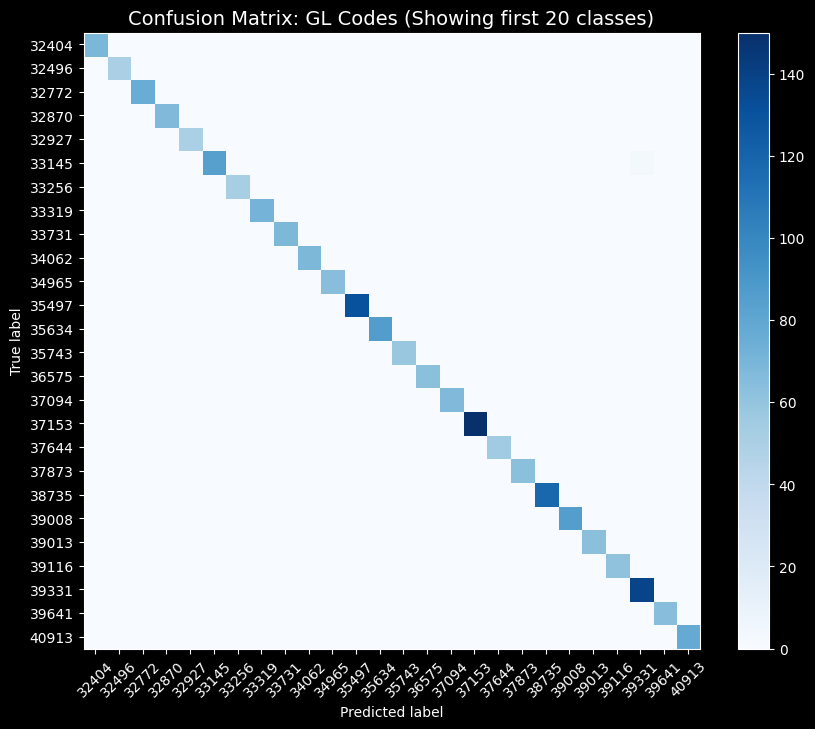

  Accuracy -> Type: 0.9985 | Code: 0.9985
Dataset Loaded: 10000 records
Found 12 Transaction Types and 25 GL Codes.


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter company_D was active which is now deleted. Setting active adapter to default.
  warnings.warn(
Map: 100%|██████████| 2000/2000 [00:00<00:00, 54297.31 examples/s]



--- Validating: company_E ---



--- Random Sample Review for company_E ---
[1309] Type: POS_TYB -> POS_TYB ✅ | Code: 22489 -> 22489 ✅
[228] Type: POS_JAR -> POS_JAR ✅ | Code: 27257 -> 27257 ✅
[51] Type: Auto_YDJ -> Auto_YDJ ✅ | Code: 26462 -> 26462 ✅
[1518] Type: Auto_YDJ -> Auto_YDJ ✅ | Code: 22489 -> 22489 ✅
[563] Type: POS_JAR -> POS_JAR ✅ | Code: 27805 -> 27805 ✅
[501] Type: Fee_FPI -> Fee_FPI ✅ | Code: 26002 -> 26002 ✅
[457] Type: Wire_GZU -> Wire_GZU ✅ | Code: 28996 -> 28996 ✅
[285] Type: Wire_ZYW -> Wire_ZYW ✅ | Code: 27619 -> 27619 ✅
[1508] Type: POS_SNH -> POS_SNH ✅ | Code: 27628 -> 27628 ✅
[209] Type: POS_JAR -> POS_JAR ✅ | Code: 27805 -> 27805 ✅
=== Transaction Types ===
Precision: 1.0000 | Recall: 1.0000 | F1:     1.0000 for company : company_E
=== GL Codes ===
Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 for company : company_E
Generating Confusion Matrix for Transaction Types...


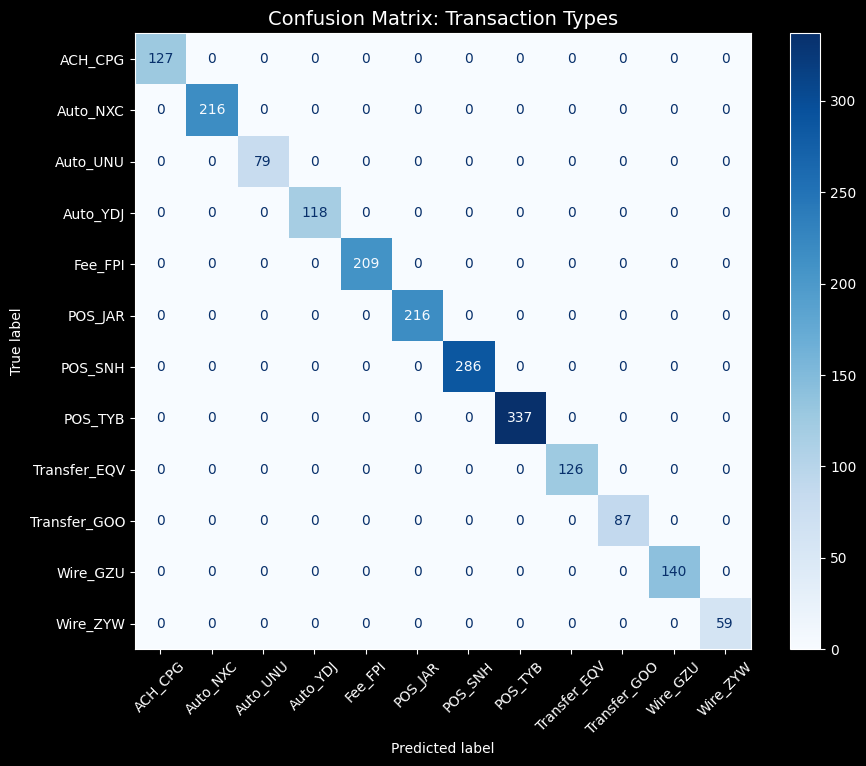

Generating Confusion Matrix for GL Codes...


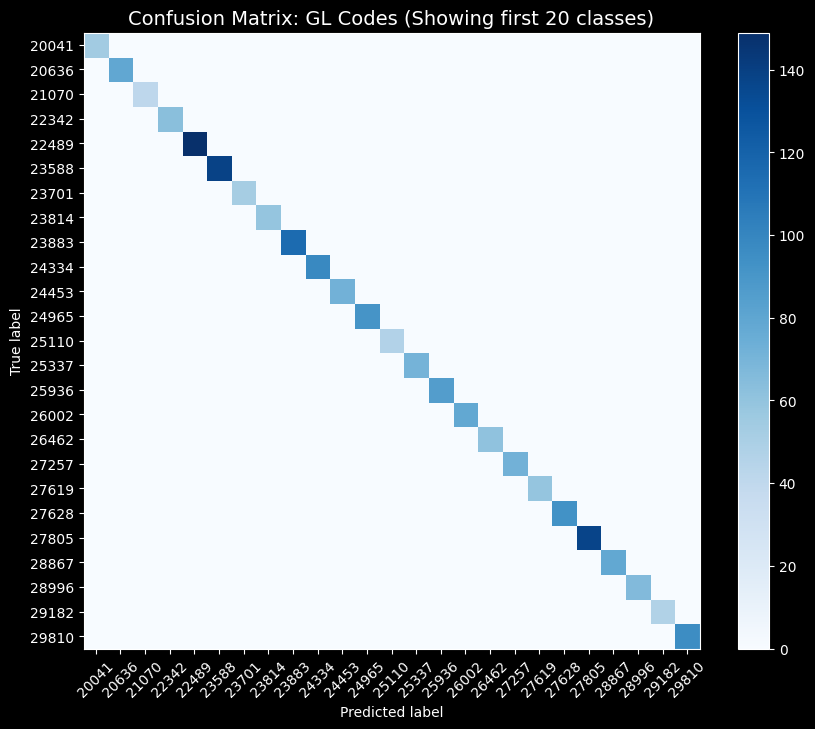

  Accuracy -> Type: 1.0000 | Code: 1.0000
Dataset Loaded: 10000 records
Found 13 Transaction Types and 27 GL Codes.


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter company_E was active which is now deleted. Setting active adapter to default.
  warnings.warn(
Map: 100%|██████████| 2000/2000 [00:00<00:00, 54989.60 examples/s]



--- Validating: company_F ---



--- Random Sample Review for company_F ---
[1309] Type: POS_ZUC -> POS_ZUC ✅ | Code: 72783 -> 72783 ✅
[228] Type: Fee_QAN -> Fee_QAN ✅ | Code: 70240 -> 70240 ✅
[51] Type: Fee_QKA -> Fee_QKA ✅ | Code: 75191 -> 75191 ✅
[1518] Type: Fee_ZUT -> Fee_ZUT ✅ | Code: 66454 -> 66454 ✅
[563] Type: Fee_RDT -> Fee_RDT ✅ | Code: 72921 -> 72921 ✅
[501] Type: POS_ZUC -> POS_ZUC ✅ | Code: 72783 -> 72783 ✅
[457] Type: POS_FPA -> POS_FPA ✅ | Code: 72783 -> 72783 ✅
[285] Type: Wire_HJN -> Wire_HJN ✅ | Code: 71778 -> 71778 ✅
[1508] Type: POS_ZUC -> POS_ZUC ✅ | Code: 69784 -> 69784 ✅
[209] Type: POS_ZUC -> POS_ZUC ✅ | Code: 69787 -> 69787 ✅
=== Transaction Types ===
Precision: 1.0000 | Recall: 1.0000 | F1:     1.0000 for company : company_F
=== GL Codes ===
Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 for company : company_F
Generating Confusion Matrix for Transaction Types...


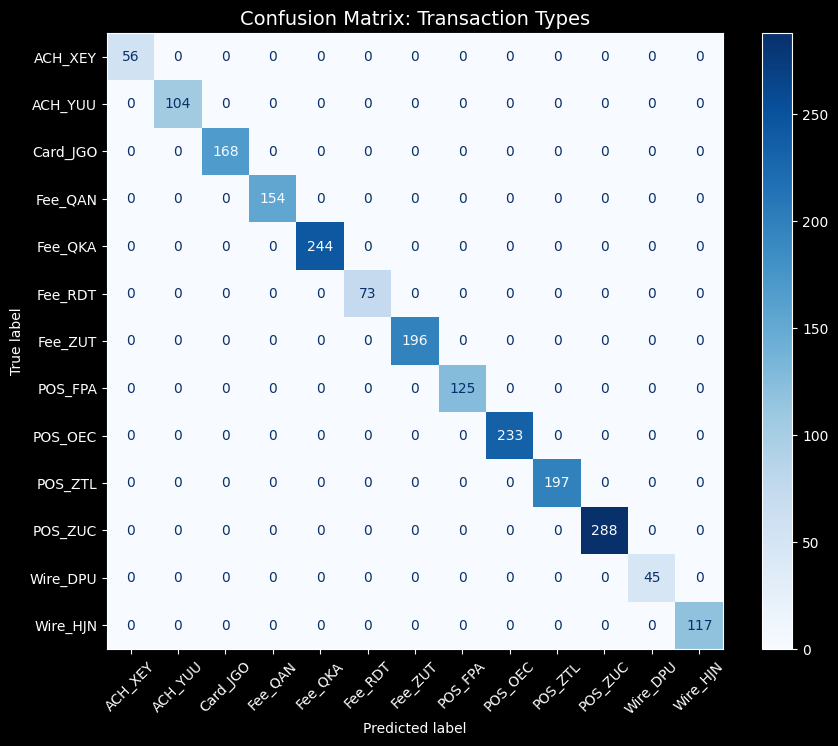

Generating Confusion Matrix for GL Codes...


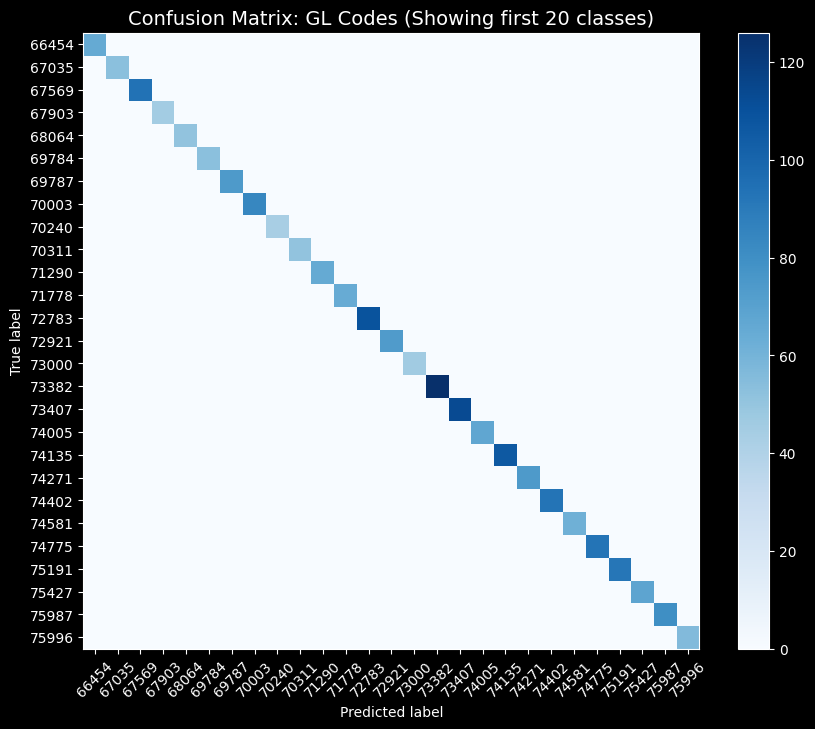

  Accuracy -> Type: 1.0000 | Code: 1.0000


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter company_F was active which is now deleted. Setting active adapter to default.
  warnings.warn(


In [6]:
# VALIDATING COMPANY ADAPTERS


import torch
import os
import numpy as np
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModel
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# --- 1. Global Setup (Run ONCE) ---
model_id = "Qwen/Qwen2.5-1.5B"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define standard LoRA Config (Must match training!)
peft_config = LoraConfig(
    #  treat the Qwen backbone as a feature extractor.as we have custom multihead QWEN ,
    # normal classification this would have been SEQ_CLS
    # classification heads are external to the PEFT wrapper here
    task_type=TaskType.FEATURE_EXTRACTION, 
    r=8, # 16 RANk is good , LORA Mattrices will be A X R and R X B . 
    lora_alpha=16, # Scales Output of Lora adapter by Alpha / Rank . ( 32/16 for us) , Makes learnt weights LOUDER compared to base model weights .
    #Scale of 2 is good . 
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], # Q K V and Output Projections selected to train as part of adapter 
    # MLP Layers are gate_proj, up_proj, down_proj , but results in very large number of paramters to learn but also gives huge accuracy benefit . 
    lora_dropout=0.05 # Prevents overfittig whern data sizes are small like our company data case. 
)

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        return logits
    return logits

# Initialize Base Model Wrapper ONCE
# We start with dummy head sizes; we will resize them per company later.
print("Loading Base Model (this takes time)...")
base_model_wrapper = QwenMultiHeadClassifier(
    model_id=model_id,
    num_type_labels=2, # Dummy
    num_code_labels=2  # Dummy
)

print(f"QWEn Multihead with 2 linear heads :\n {base_model_wrapper}")

# CRITICAL FIX 1: Resize Embeddings immediately
# This prevents "device-side assert" errors if tokenizer > model
base_model_wrapper.qwen.resize_token_embeddings(len(tokenizer))

# CRITICAL FIX 2: Wrap in PEFT immediately
# This adds the "base_model.model..." structure so load_adapter works
base_model_wrapper.qwen = get_peft_model(base_model_wrapper.qwen, peft_config)

# Move to GPU once
base_model_wrapper.to("cuda")

def plot_cm(cm, class_names, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Filter for readability if you have too many classes
    if len(class_names) > 20:
        plt.title(f"{title} (Showing first 20 classes)", fontsize=14)
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, include_values=False) # Hide numbers if dense
    else:
        plt.title(title, fontsize=14)
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)

    plt.show()
# --- 2. Validation Function ---
def validate_company(model, company_name, adapters_root_dir, val_dataset):
    print(f"\n--- Validating: {company_name} ---")
    adapter_path = os.path.join(adapters_root_dir, company_name)

    # A. Dynamic Head Resizing
    # We must resize heads to match the saved checkpoint BEFORE loading weights
    try:
        # Load state dicts to cpu to inspect shapes
        type_state = torch.load(os.path.join(adapter_path, "type_head.bin"), map_location="cpu")
        code_state = torch.load(os.path.join(adapter_path, "code_head.bin"), map_location="cpu")

        n_types = type_state['weight'].shape[0]
        n_codes = code_state['weight'].shape[0]

        # Resize the linear layers on the model
        # We reuse the existing dtype/device
        dtype = model.qwen.dtype
        device = model.qwen.device

        model.type_head = torch.nn.Linear(model.config.hidden_size, n_types).to(device=device, dtype=dtype)
        model.code_head = torch.nn.Linear(model.config.hidden_size, n_codes).to(device=device, dtype=dtype)

        # Load weights
        model.type_head.load_state_dict(type_state)
        model.code_head.load_state_dict(code_state)

    except FileNotFoundError:
        print(f"Skipping {company_name}: Head weights not found.")
        return None

    # B. Load LoRA Adapter
    try:
        # load_adapter adds the weights.
        # Note: Since we already wrapped in get_peft_model, this should match keys correctly.
        model.qwen.load_adapter(adapter_path, adapter_name=company_name)
        model.qwen.set_adapter(company_name)
    except Exception as e:
        print(f"Skipping {company_name}: Adapter load failed. {e}")
        return None

    # C. Inference
    eval_trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./temp_eval",
            per_device_eval_batch_size=32,
            remove_unused_columns=False, # Essential for custom models
            report_to="none"
        ),
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    )

    # Predict
    # pass ignore_keys to avoid gathering 'loss' which might be None
    preds = eval_trainer.predict(val_dataset, ignore_keys=["loss", "hidden_states", "attentions"])

    logits_type, logits_code = preds.predictions

    # D. Metrics
    pred_types = np.argmax(logits_type, axis=1)
    pred_codes = np.argmax(logits_code, axis=1)
    true_types = np.array(val_dataset['labels_type'])
    true_codes = np.array(val_dataset['labels_code'])

    print(f"\n--- Random Sample Review for {company_name} ---")
    import random
    num_samples = len(true_types)
    random_indices = random.sample(range(num_samples), min(10, num_samples))
    type_encoder = data_bundle["encoders"]["type"] # Pass data_bundle to validate_company or encoders
    code_encoder = data_bundle["encoders"]["code"]

    for idx in random_indices:
        # Inverse transform IDs to Strings
        actual_type_str = type_encoder.inverse_transform([true_types[idx]])[0]
        actual_code_str = code_encoder.inverse_transform([true_codes[idx]])[0]

        pred_type_str = type_encoder.inverse_transform([pred_types[idx]])[0]
        pred_code_str = code_encoder.inverse_transform([pred_codes[idx]])[0]

        # Check correctness
        type_match = "✅" if true_types[idx] == pred_types[idx] else "❌"
        code_match = "✅" if true_codes[idx] == pred_codes[idx] else "❌"

        print(f"[{idx}] Type: {actual_type_str} -> {pred_type_str} {type_match} | Code: {actual_code_str} -> {pred_code_str} {code_match}")

    p_type = precision_score(true_types, pred_types, average='weighted', zero_division=0)
    r_type = recall_score(true_types, pred_types, average='weighted', zero_division=0)
    f1_type = f1_score(true_types, pred_types, average='weighted', zero_division=0)

    p_code = precision_score(true_codes, pred_codes, average='weighted', zero_division=0)
    r_code = recall_score(true_codes, pred_codes, average='weighted', zero_division=0)
    f1_code = f1_score(true_codes, pred_codes, average='weighted', zero_division=0)

    print(f"=== Transaction Types ===\nPrecision: {p_type:.4f} | Recall: {r_type:.4f} | F1:     {f1_type:.4f} for company : {company}")
    print(f"=== GL Codes ===\nPrecision: {p_code:.4f} | Recall: {r_code:.4f} | F1: {f1_code:.4f} for company : {company}")

    acc_type = accuracy_score(true_types, pred_types)
    acc_code = accuracy_score(true_codes, pred_codes)

    type_classes = data_bundle["encoders"]["type"].classes_
    code_classes = data_bundle["encoders"]["code"].classes_
    
    cm_type = confusion_matrix(true_types, pred_types)
    cm_code = confusion_matrix(true_codes, pred_codes)
    print("Generating Confusion Matrix for Transaction Types...")
    plot_cm(cm_type, type_classes, "Confusion Matrix: Transaction Types")

    print("Generating Confusion Matrix for GL Codes...")
    plot_cm(cm_code, code_classes, "Confusion Matrix: GL Codes")


    print(f"  Accuracy -> Type: {acc_type:.4f} | Code: {acc_code:.4f}")

    # E. Cleanup
    # Delete adapter to free memory for next company
    model.qwen.delete_adapter(company_name)

    return {"company": company_name, "acc_type": acc_type, "acc_code": acc_code}

# --- 3. Execution Loop ---
results = []
companies = ["company_D", "company_E", "company_F"]
#, "company_E", "company_F"
for company in companies:
    # Get Data
    data_bundle = get_company_dataset(company, tokenizer)

    # Validate using the SHARED model instance
    res = validate_company(base_model_wrapper, company, "./final_adapters", data_bundle['val'])
    if res:
        results.append(res)


In [7]:
# VALIDATING GLOBAL ADAPTER

import torch
import os
import numpy as np
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModel
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# --- 1. Global Setup (Run ONCE) ---
model_id = "Qwen/Qwen2.5-1.5B"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
adapter_name_global = "adapter_global"
global_adapter_path = "./final_adapters_QWEN/global"
# Define standard LoRA Config (Must match training!)
peft_config = LoraConfig(
    #  treat the Qwen backbone as a feature extractor.as we have custom multihead QWEN ,
    # normal classification this would have been SEQ_CLS
    # classification heads are external to the PEFT wrapper here
    task_type=TaskType.FEATURE_EXTRACTION, 
    r=8, # 16 RANk is good , LORA Mattrices will be A X R and R X B . 
    lora_alpha=16, # Scales Output of Lora adapter by Alpha / Rank . ( 32/16 for us) , Makes learnt weights LOUDER compared to base model weights .
    #Scale of 2 is good . 
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], # Q K V and Output Projections selected to train as part of adapter 
    # MLP Layers are gate_proj, up_proj, down_proj , but results in very large number of paramters to learn but also gives huge accuracy benefit . 
    lora_dropout=0.05 # Prevents overfittig whern data sizes are small like our company data case. 
)

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        return logits
    return logits

# Initialize Base Model Wrapper ONCE
# We start with dummy head sizes; we will resize them per company later.
print("Loading Base Model (this takes time)...")
model = QwenMultiHeadClassifier(
    model_id=model_id,
    num_type_labels=2, # Dummy
    num_code_labels=2  # Dummy
)

print(f"QWEn Multihead with 2 linear heads :\n {model}")

# CRITICAL FIX 1: Resize Embeddings immediately
# This prevents "device-side assert" errors if tokenizer > model
model.qwen.resize_token_embeddings(len(tokenizer))

# CRITICAL FIX 2: Wrap in PEFT immediately
# This adds the "base_model.model..." structure so load_adapter works
model.qwen = get_peft_model(model.qwen, peft_config)

# Move to GPU once
model.to("cuda")

def plot_cm(cm, class_names, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Filter for readability if you have too many classes
    if len(class_names) > 20:
        plt.title(f"{title} (Showing first 20 classes)", fontsize=14)
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, include_values=False) # Hide numbers if dense
    else:
        plt.title(title, fontsize=14)
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)

    plt.show()

def load_global_adapter():
    try:
        # Load state dicts to cpu to inspect shapes
        type_state = torch.load(os.path.join(global_adapter_path, "type_head.bin"), map_location="cpu")
        code_state = torch.load(os.path.join(global_adapter_path, "code_head.bin"), map_location="cpu")

        n_types = type_state['weight'].shape[0]
        n_codes = code_state['weight'].shape[0]

        # Resize the linear layers on the model
        # We reuse the existing dtype/device
        dtype = model.qwen.dtype
        device = model.qwen.device

        model.type_head = torch.nn.Linear(model.config.hidden_size, n_types).to(device=device, dtype=dtype)
        model.code_head = torch.nn.Linear(model.config.hidden_size, n_codes).to(device=device, dtype=dtype)

        # Load weights
        model.type_head.load_state_dict(type_state)
        model.code_head.load_state_dict(code_state)

    except FileNotFoundError:
        print(f"Skipping Global Adapter: Head weights not found.")
        return None

    # B. Load LoRA Adapter
    try:
        # load_adapter adds the weights.
        # Note: Since we already wrapped in get_peft_model, this should match keys correctly.
        model.qwen.load_adapter(global_adapter_path, adapter_name_global)
        model.qwen.set_adapter(adapter_name_global)
        return model
    except Exception as e:
        print(f"Skipping Global Adapter Loading : Adapter load failed. {e}")
        return None

# --- 2. Validation Function ---
def validate_global_adapter(model, company_name,  val_dataset):
    print(f"\n--- Validating: GLOBAL Adapter, data for company {company_name}")

    # C. Inference
    eval_trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./temp_eval",
            per_device_eval_batch_size=32,
            remove_unused_columns=False, # Essential for custom models
            report_to="none"
        ),
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    )

    # Predict
    # pass ignore_keys to avoid gathering 'loss' which might be None
    preds = eval_trainer.predict(val_dataset, ignore_keys=["loss", "hidden_states", "attentions"])

    logits_type, logits_code = preds.predictions

    # D. Metrics
    pred_types = np.argmax(logits_type, axis=1)
    pred_codes = np.argmax(logits_code, axis=1)
    true_types = np.array(val_dataset['labels_type'])
    true_codes = np.array(val_dataset['labels_code'])

    print(f"\n--- Random Sample Review for {company_name} ---")
    import random
    num_samples = len(true_types)
    random_indices = random.sample(range(num_samples), min(10, num_samples))
    type_encoder = data_bundle["encoders"]["type"] # Pass data_bundle to validate_company or encoders
    code_encoder = data_bundle["encoders"]["code"]

    for idx in random_indices:
        # Inverse transform IDs to Strings
        actual_type_str = type_encoder.inverse_transform([true_types[idx]])[0]
        actual_code_str = code_encoder.inverse_transform([true_codes[idx]])[0]

        pred_type_str = type_encoder.inverse_transform([pred_types[idx]])[0]
        pred_code_str = code_encoder.inverse_transform([pred_codes[idx]])[0]

        # Check correctness
        type_match = "✅" if true_types[idx] == pred_types[idx] else "❌"
        code_match = "✅" if true_codes[idx] == pred_codes[idx] else "❌"

        print(f"[{idx}] Type: {actual_type_str} -> {pred_type_str} {type_match} | Code: {actual_code_str} -> {pred_code_str} {code_match}")

    p_type = precision_score(true_types, pred_types, average='weighted', zero_division=0)
    r_type = recall_score(true_types, pred_types, average='weighted', zero_division=0)
    f1_type = f1_score(true_types, pred_types, average='weighted', zero_division=0)

    p_code = precision_score(true_codes, pred_codes, average='weighted', zero_division=0)
    r_code = recall_score(true_codes, pred_codes, average='weighted', zero_division=0)
    f1_code = f1_score(true_codes, pred_codes, average='weighted', zero_division=0)

    print(f"=== Transaction Types ===\nPrecision: {p_type:.4f} | Recall: {r_type:.4f} | F1:     {f1_type:.4f} for company : {company}")
    print(f"=== GL Codes ===\nPrecision: {p_code:.4f} | Recall: {r_code:.4f} | F1: {f1_code:.4f} for company : {company}")

    acc_type = accuracy_score(true_types, pred_types)
    acc_code = accuracy_score(true_codes, pred_codes)

    type_classes = data_bundle["encoders"]["type"].classes_
    code_classes = data_bundle["encoders"]["code"].classes_
    
    cm_type = confusion_matrix(true_types, pred_types)
    cm_code = confusion_matrix(true_codes, pred_codes)
    print("Generating Confusion Matrix for Transaction Types...")
    plot_cm(cm_type, type_classes, "Confusion Matrix: Transaction Types")

    print("Generating Confusion Matrix for GL Codes...")
    plot_cm(cm_code, code_classes, "Confusion Matrix: GL Codes")


    print(f"  Accuracy -> Type: {acc_type:.4f} | Code: {acc_code:.4f}")

    # E. Cleanup
    # Delete adapter to free memory for next company
    model.qwen.delete_adapter(company_name)

    return {"company": company_name, "acc_type": acc_type, "acc_code": acc_code}

# --- 3. Execution Loop ---
results = []
companies = ["company_D", "company_E"]
model = load_global_adapter()        
#, "company_E", "company_F"
for company in companies:
    # Get Data
    data_bundle = get_company_dataset(company, tokenizer)

    # Validate using the SHARED model instance
    res = validate_global_adapter(model, company , data_bundle['val'])
    if res:
        results.append(res)


Loading Base Model (this takes time)...


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1411.29it/s, Materializing param=norm.weight]                              


QWEn Multihead with 2 linear heads :
 QwenMultiHeadClassifier(
  (qwen): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm):

Map: 100%|██████████| 2000/2000 [00:00<00:00, 53492.63 examples/s]



--- Validating: GLOBAL Adapter, data for company company_D


AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
